In [1]:
import pandas as pd

In [2]:
b1 = pd.read_csv('/home/db24/irp-db24/b1.txt', header=None, sep=' ')
b2 = pd.read_csv('/home/db24/irp-db24/b2.txt', header=None, sep=' ')

In [3]:
## Preprocessing function

def preprocess(df):
    df = df.drop(columns=[3])
    df = df.rename(columns={0: 'heart_rate', 1: 'chest_volume', 2: 'blood_oxygen_conc'}) 
    df["time_seconds"] = df.index * 0.5
    return df

b1_final = preprocess(b1)
b2_final = preprocess(b2)

In [4]:
final_df = pd.concat([b1_final, b2_final], ignore_index=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# 1. Separate features to scale and features to exclude
cols_to_exclude = ["time_seconds"]
cols_to_scale = final_df.columns.difference(cols_to_exclude)

# 2. Apply scaler only to selected columns
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(final_df[cols_to_scale])

# 3. Reconstruct scaled DataFrame
scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale)

# 4. Add back the excluded column(s)
scaled_df[cols_to_exclude] = final_df[cols_to_exclude].reset_index(drop=True)



In [6]:
scaled_df

,blood_oxygen_conc,chest_volume,heart_rate,time_seconds
0,0.987724,0.627176,0.705599,0.0
1,0.987808,0.624076,0.705599,0.5
2,0.988198,0.616489,0.702082,1.0
3,0.988170,0.598061,0.695049,1.5
4,0.987612,0.614931,0.696159,2.0
...,...,...,...,...
33995,0.992244,0.705863,0.559278,8497.5
33996,0.994085,0.703756,0.552615,8498.0
33997,0.994866,0.703313,0.546043,8498.5
33998,0.994978,0.703725,0.539750,8499.0


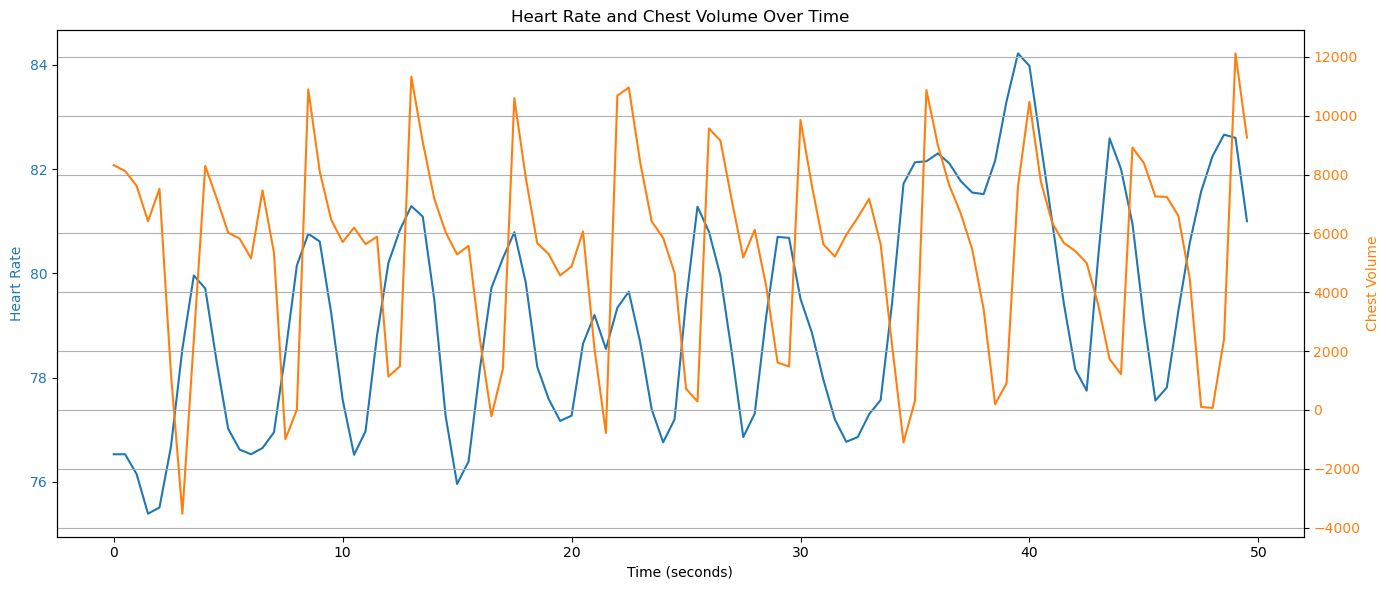

In [7]:
import matplotlib.pyplot as plt

plot_df = final_df[:100]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary y-axis (Heart Rate)
ax1.plot(plot_df["time_seconds"], plot_df["heart_rate"], color='tab:blue', label="Heart Rate")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Heart Rate", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis (Chest Volume)
ax2 = ax1.twinx()
ax2.plot(plot_df["time_seconds"], plot_df["chest_volume"], color='tab:orange', label="Chest Volume")
ax2.set_ylabel("Chest Volume", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and Grid
plt.title("Heart Rate and Chest Volume Over Time")
fig.tight_layout()
plt.grid(True)
plt.show()


## It looks fine, heart rate increases during inhalation

In [ ]:
## Splitting the data into sequences for time series analysis
import numpy as np
def create_multistep_sequences(data, input_steps=30, output_steps=10):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

features =scaled_df[["blood_oxygen_conc", "chest_volume", "heart_rate"]].values

X10, y10 = create_multistep_sequences(features, input_steps=10, output_steps=10)
# X20, y20 = create_multistep_sequences(features, input_steps=30, output_steps=10)
# X30, y30 = create_multistep_sequences(features, input_steps=50, output_steps=10)


In [9]:
from tensorflow.keras import layers, Model, Input, backend as K
import tensorflow as tf

input_dim = 3 # Each timestep has 3 features: blood_oxygen_conc, chest_volume, heart_rate
timesteps = 10 # Number of timesteps in each sequence - might change it later on
latent_dim = 64 # The latent space vector will have 16 dimensions


## ------------------------- ENCODER ---------------------------------
# Encoder
encoder_inputs = Input(shape=(timesteps, input_dim))
print("Encoder input shape:", encoder_inputs.shape)
x = layers.Flatten()(encoder_inputs)
print("After flattening:", x.shape)
x = layers.Dense(latent_dim, activation="relu")(x) ## --> extracting compressed representation
print("After first dense layer:", x.shape)
x = layers.Dropout(0.2)(x) 
# x = layers.Dense(latent_dim, activation="relu", name="enc_dense_2")(x)
# x = layers.Dropout(0.2, name="enc_dropout_2")(x)
### ------------------- This is VAE - I am encoding a distribution not a vector (latent representation of the data) ----------
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -10., 10.))(z_log_var)

# Sampling layer (reparameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="sampling")([z_mean, z_log_var])


## ------------------------- DECODER ---------------------------------
# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = layers.Dense(latent_dim, activation="relu")(decoder_inputs)
x = layers.Dropout(0.2)(x) 
# x = layers.Dense(latent_dim, activation="relu", name="dec_dense_2")(x)
# x = layers.Dropout(0.2, name="dec_dropout_2")(x)
decoder_outputs = layers.Dense(input_dim * 10)(x)
decoder_outputs = layers.Reshape((10, input_dim))(decoder_outputs)  # shape: (None, 10, 3)

decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

vae_outputs = decoder(z)

# VAE model
vae = Model(encoder_inputs, vae_outputs, name="vae")

# KL divergence loss added internally
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae.add_loss(K.mean(kl_loss) * 1e-3)  # small weight for KL divergence


Encoder input shape: (None, 10, 3)
After flattening: (None, 30)
After first dense layer: (None, 64)


2025-06-03 09:00:53.154763: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-06-03 09:00:53.155036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 09:00:53.157631: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
vae.compile(optimizer="adam", loss="mse")  # only reconstruction loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history1 = vae.fit(X10, y10, epochs=20, batch_size=128, validation_split=0.3, callbacks=[early_stop])
# history2 = vae.fit(X20, y20, epochs=20, batch_size=128, validation_split=0.3, callbacks=[early_stop])
# history3 = vae.fit(X30, y30, epochs=20, batch_size=128, validation_split=0.3, callbacks=[early_stop])

2025-06-03 09:00:53.343364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-06-03 09:00:53.348716: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688010000 Hz


Epoch 1/20
186/186 [==============================] - 3s 12ms/step - loss: 0.4721 - val_loss: 0.0685
Epoch 2/20
186/186 [==============================] - 2s 9ms/step - loss: 0.0730 - val_loss: 0.0519
Epoch 3/20
186/186 [==============================] - 2s 9ms/step - loss: 0.0486 - val_loss: 0.0440
Epoch 4/20
186/186 [==============================] - 3s 16ms/step - loss: 0.0360 - val_loss: 0.0397
Epoch 5/20
186/186 [==============================] - 2s 9ms/step - loss: 0.0273 - val_loss: 0.0363
Epoch 6/20
186/186 [==============================] - 2s 10ms/step - loss: 0.0212 - val_loss: 0.0335
Epoch 7/20
186/186 [==============================] - 2s 10ms/step - loss: 0.0176 - val_loss: 0.0326
Epoch 8/20
186/186 [==============================] - 2s 13ms/step - loss: 0.0152 - val_loss: 0.0312
Epoch 9/20
186/186 [==============================] - 3s 15ms/step - loss: 0.0134 - val_loss: 0.0304
Epoch 10/20
186/186 [==============================] - 14s 75ms/step - loss: 0.0119 - val_loss

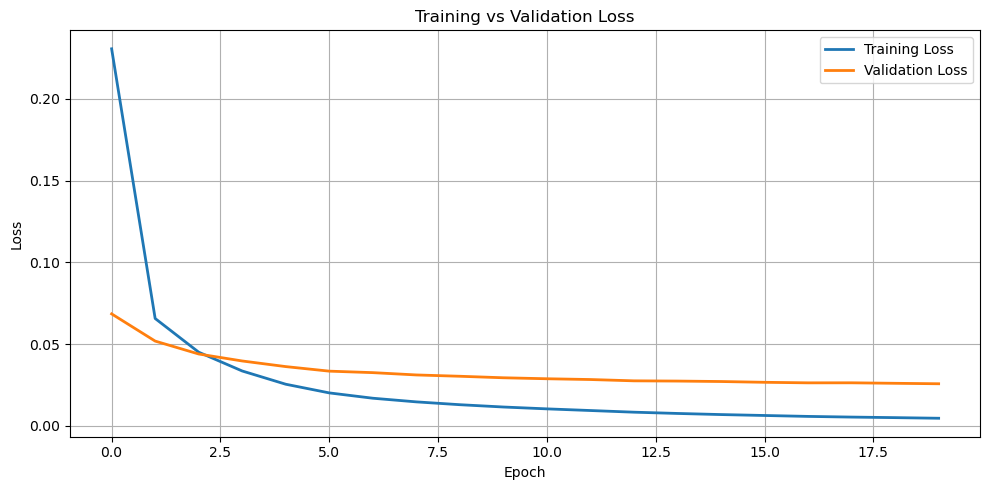

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

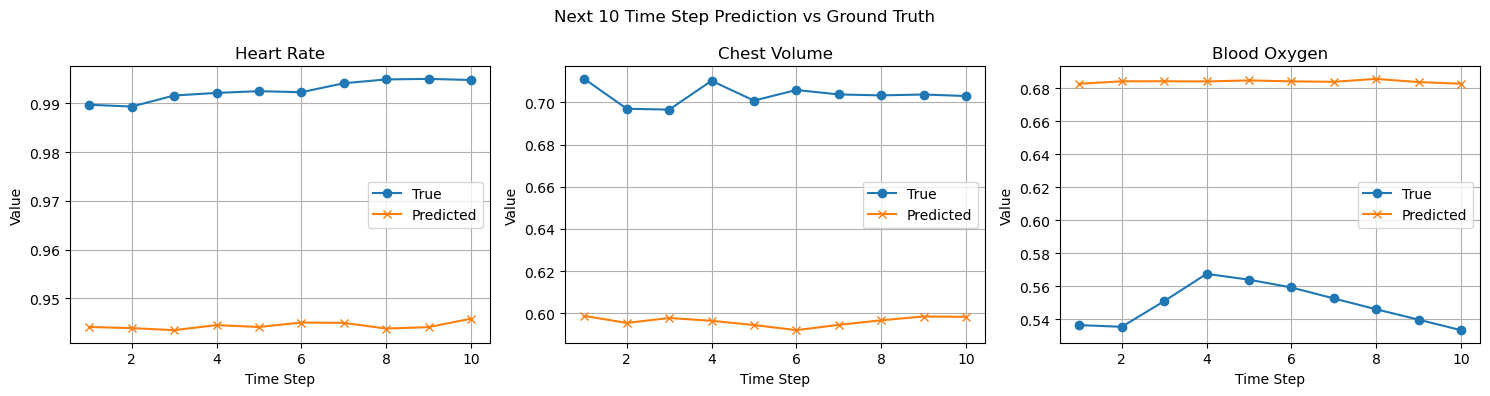

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get the last input sequence and target
pred = vae.predict(X10[-1:])  # shape: (1, 10, 3)
true = y10[-1]                # shape: (10, 3)

# Plot
time_steps = np.arange(1, 11)
variables = ['Heart Rate', 'Chest Volume', 'Blood Oxygen']

plt.figure(figsize=(15, 4))

for j in range(3):
    plt.subplot(1, 3, j+1)
    plt.plot(time_steps, true[:, j], label='True', marker='o')
    plt.plot(time_steps, pred[0, :, j], label='Predicted', marker='x')
    plt.title(variables[j])
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.suptitle('Next 10 Time Step Prediction vs Ground Truth')
plt.tight_layout()
plt.show()


## APPENDIX

train.dtypes()

In [13]:
# ## Importing data

# ## the path for one file is /home/db24/irp-db24/Fitbit_heart_rate_all/p01/fitbit/calories.json
# overall_path = "/home/db24/irp-db24/Fitbit_heart_rate_all/p05/fitbit/"

# df_calories = pd.read_json(overall_path + "calories.json")  # Different path
# df_distance = pd.read_json(overall_path + "distance.json")
# df_exercise = pd.read_json(overall_path + "exercise.json")
# df_heart = pd.read_json(overall_path + "heart_rate.json")
# df_act_mins = pd.read_json(overall_path + "lightly_active_minutes.json")
# df_rest_hr = pd.read_json(overall_path + "resting_heart_rate.json")
# df_sed_mins = pd.read_json(overall_path + "sedentary_minutes.json")
# df_sleep = pd.read_json(overall_path + "sleep.json")
# df_steps = pd.read_json(overall_path + "steps.json")
# df_very_active_mins = pd.read_json(overall_path + "very_active_minutes.json")

In [14]:
# # Merge the data together by time
# # Normalise the data
# # Feed to a model and predict next minute

# def rename_second_column_to_value(df, prefix):
#     new_columns = df.columns.tolist()
#     new_columns[1] = prefix + "_value"
#     df.columns = new_columns
#     return df

# df_calories  =rename_second_column_to_value(df_calories, "calories")
# df_distance = rename_second_column_to_value(df_distance, "distance")
# df_heart = rename_second_column_to_value(df_heart, "heart_rate") ## PROBLEM NEETO TO EXTRACT
# df_act_mins = rename_second_column_to_value(df_act_mins, "lightly_active_minutes")
# df_sed_mins = rename_second_column_to_value(df_sed_mins, "sedentary_minutes")
# df_sleep_pre = rename_second_column_to_value(df_sleep, "sleep") ## also needs to be changed
# df_steps = rename_second_column_to_value(df_steps, "steps")
# df_very_active_mins = rename_second_column_to_value(df_very_active_mins, "very_active_minutes")


# ## Preprocessing data
# df_sleep_post = df_sleep_pre[["startTime", "duration"]]
# df_sleep_post.rename(columns={"startTime": "dateTime"}, inplace=True)
# df_heart['heart_rate_value'] = df_heart['heart_rate_value'].apply(
#     lambda x: x['bpm'] if isinstance(x, dict) and 'bpm' in x else None
# )

In [15]:
# from functools import reduce

# def merge_all_features(*dfs):
#     # Convert dateTime column in each df to datetime64
#     dfs = [df.copy() for df in dfs]  # prevent modifying original dfs
#     for df in dfs:
#         df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')

#     return reduce(lambda left, right: pd.merge(left, right, on='dateTime', how='outer'), dfs)

# all_combined = merge_all_features(
#     df_calories,
#     df_distance,
#     df_heart,
#     df_act_mins,
#     df_sed_mins,
#     df_sleep_post,
#     df_steps,
#     df_very_active_mins
# )


In [16]:
# all_combined["distance_value"].value_counts()

In [17]:
# scaler = MinMaxScaler()

# ## Scale all_combined data besides dateTime
# scaled_columns = all_combined.columns.difference(['dateTime'])
# all_combined[scaled_columns] = scaler.fit_transform(all_combined[scaled_columns])

In [18]:
# all_combined = all_combined.dropna()
# all_combined

In [19]:
# all_combined.isna().sum() / len(all_combined) * 100  # Percentage of NaN values in each column
